In [ ]:
# NOTES:
# 1. albumentations -> numpy
# 2. pil.open faster than cv2
# 3. 

In [1]:
import numpy as np
import pandas as pd
import os

from pathlib import Path


import numpy as np
import torchvision
import matplotlib.pyplot as plt

import torch
from torchvision import transforms, models

from albumentations import Compose, ToGray, Normalize, RandomCrop, OneOf
from albumentations.pytorch import ToTensor
from torch.utils.data import Dataset, DataLoader

from PIL import Image
from colour_demosaicing import demosaicing_CFA_Bayer_Menon2007

print(os.listdir())

['data_preprocess.ipynb', '.DS_Store', 'CNN.ipynb', 'raw_images', 'noise_est.ipynb', 'custom_convolution.ipynb', 'train', '.ipynb_checkpoints', 'Baseline in PyTorch.ipynb', 'Baseline in PyTorch-2.ipynb', 'val']


In [36]:
def get_awgn_image(image, scale, loc=0.0):
    # scale = sigma
    noise3d = np.random.normal(loc=loc, scale=scale, size=image.shape)
    noisy_image = np.uint8(np.clip(image + noise3d, 0, 255))
    return noisy_image


def get_rgb_masks(shape):
    # GRBG
    g = np.zeros(shape)
    
    g[::2, ::2] = 1
    g[1::2, 1::2] = 1
    
    b = np.zeros(shape)
    b[1::2, ::2] = 1
    
    r = np.zeros(shape)
    r[::2, 1::2] = 1
    
    return r, g, b
    

def mosaic(image, rgb=True):
    h, w, _ = image.shape
    r_mask, g_mask, b_mask = get_rgb_masks((h,w))
    if rgb:
        blue, green, red = image[:, :, 2], image[:, :, 1], image[:, :, 0]
    else:
        blue, green, red = image[:, :, 0], image[:, :, 1], image[:, :, 2]
    return blue * b_mask + green * g_mask + red * r_mask


def mosaic_awgn_demosaic(image, sigma, rgb=True):
    mosaic_im = mosaic(image, rgb=rgb)
    noisy_mosaic_im = get_awgn_image(mosaic_im, sigma)
    demosaic_noisy_im = demosaicing_CFA_Bayer_Menon2007(noisy_mosaic_im, 'GRBG')
    if rgb:
        return demosaic_noisy_im
    # rgb to bgr
    return demosaic_noisy_im[:, :, [2, 1, 0]]


class ImageDataset(Dataset):

    def __init__(self, image_paths, augmentations=None, max_sigma=25):
        super().__init__()
        self.image_paths = image_paths
        self.size = len(image_paths)
        self.max_sigma = max_sigma
        self.augmentations = augmentations

    def __len__(self):
        return self.size
    
    def __getitem__(self, idx):
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        image_idx = np.random.randint(0, self.size)
        image = self.load_image(self.image_paths[image_idx])
        
        mode = self.get_random_mode()
        sigma = self.get_random_sigma()
        
        if mode == 'awgn':
            noisy_im = get_awgn_image(image, sigma)
        else:
            noisy_im = mosaic_awgn_demosaic(image, sigma)
            
        noisy_im = np.array(noisy_im / 255., dtype='float32')
        
        label = 0 if mode == 'bayer' else 1
        
        return transform(self.augmentations(image=noisy_im)['image']), label, sigma

    def load_image(self, image_path):
        image = Image.open(image_path)
        image.load()
        return np.array(image)
    
    def get_random_mode(self):
        return np.random.choice(['awgn', 'bayer'])
    
    def get_random_sigma(self):
        return np.random.randint(0, self.max_sigma)

## Аугментация и деление на обучение и валидацию

In [37]:
class_names = ['bayer', 'awgn']

train_transforms = Compose([
    RandomCrop(224,224),
    ToGray(p=1.0),
])

val_transforms = Compose([
    ToGray(p=1.0),
])

IMAGES_DIR = Path('raw_images/')
im_paths = list(IMAGES_DIR.rglob('*.jpg'))

n_images = len(im_paths)
n_train = int(n_images * 0.8)

train_paths = im_paths[:n_train]
val_paths = im_paths[n_train:]
print("Train size: {}\nValid size: {}".format(len(train_paths), len(val_paths)))

Train size: 4000
Valid size: 1000


In [38]:
train_dataset = ImageDataset(train_paths, train_transforms)
val_dataset = ImageDataset(val_paths, val_transforms)

batch_size = 5
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

## Пример одного батча из обучающих данных

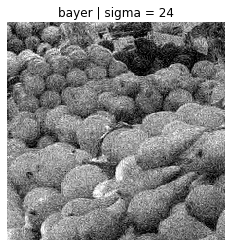

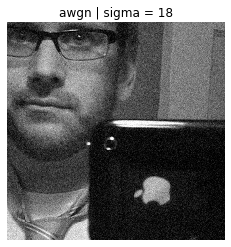

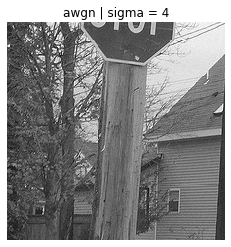

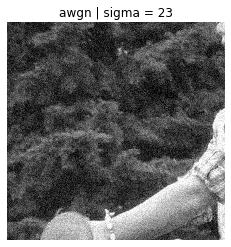

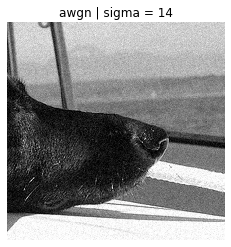

In [40]:
def show_input(input_tensor, title=''):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = input_tensor.numpy().transpose((1, 2, 0))
    image = std * image + mean
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.axis('off')
    plt.show()
    #plt.pause(0.001)

X_batch, y_batch, s_batch = next(iter(train_dataloader))

for x_item, y_item, sigma in zip(X_batch, y_batch, s_batch):
    show_input(x_item, title="{} | sigma = {}".format(class_names[y_item], sigma))

## 25 Случайных картинок из Train Dataset

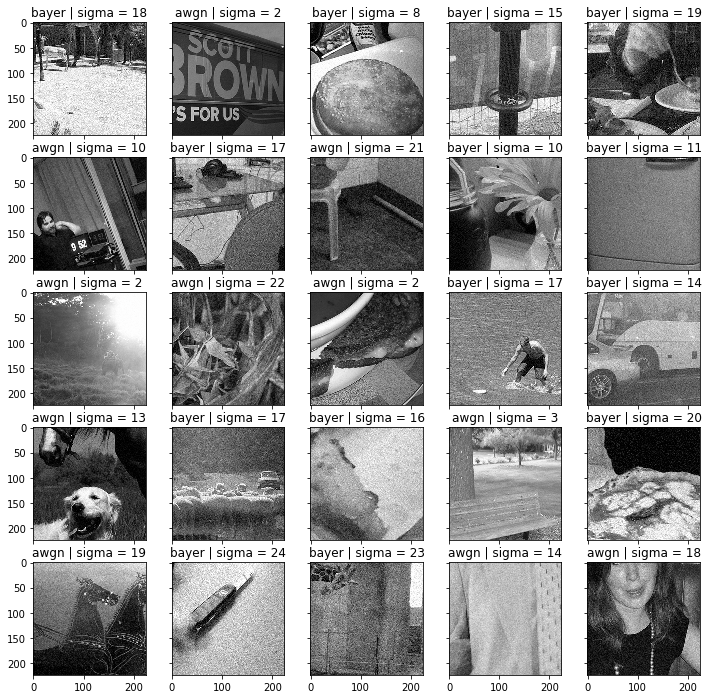

In [42]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

fig, ax = plt.subplots(nrows=5, ncols=5,figsize=(12, 12), sharey=True, sharex=True)

for fig_x in ax.flatten():
    random_plate = int(np.random.uniform(0, len(train_paths)))
    im_val, label, sigma = train_dataset[random_plate]
    imshow(im_val.data.cpu(), title="{} | sigma = {}".format(class_names[label], sigma), plt_ax=fig_x)

In [23]:
def train_model(model, loss, optimizer, scheduler, num_epochs):
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                scheduler.step()
                model.train()  # training mode
            else:
                dataloader = val_dataloader
                model.eval()   # evaluate mode (no grads)

            running_loss = 0.
            running_acc = 0.

            # Iterate over data.
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                # statistics
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)

    return model

## Обучение сети ResNet152 с последним линейным слоем

In [25]:
model = models.resnet152(pretrained=True)

model.fc = torch.nn.Linear(model.fc.in_features, 2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [26]:
loss_train_history, loss_val_history = train_model(model, loss, optimizer, scheduler, num_epochs=10)

Epoch 0/9:


/Users/mac/anaconda3/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:100: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
100%|██████████| 1/1 [00:12<00:00, 12.48s/it]

train Loss: 0.6767 Acc: 0.6667



100%|██████████| 1/1 [00:01<00:00,  1.28s/it]

val Loss: 3.5516 Acc: 0.0000
Epoch 1/9:



100%|██████████| 1/1 [00:13<00:00, 13.60s/it]

train Loss: 0.1015 Acc: 1.0000



100%|██████████| 1/1 [00:01<00:00,  1.24s/it]

val Loss: 0.9895 Acc: 0.0000
Epoch 2/9:



100%|██████████| 1/1 [00:13<00:00, 13.21s/it]

train Loss: 0.1868 Acc: 1.0000



100%|██████████| 1/1 [00:01<00:00,  1.27s/it]

val Loss: 0.0000 Acc: 1.0000
Epoch 3/9:



100%|██████████| 1/1 [00:13<00:00, 13.50s/it]

train Loss: 0.0097 Acc: 1.0000



100%|██████████| 1/1 [00:01<00:00,  1.23s/it]

val Loss: 0.0000 Acc: 1.0000
Epoch 4/9:



  0%|          | 0/1 [00:00<?, ?it/s]

KeyboardInterrupt: 

## PLOT Train and Val loss

In [ ]:
plt.plot(range(1,NUM_EPOCHS + 1), loss_train_history, loss_val_history)
plt.legend(["train", "val"])
plt.show()